In [162]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import uniform
from fairlearn.metrics import MetricFrame
from sklearn.metrics import *
from fairlearn.metrics import *
import scipy.stats.distributions as dists

In [163]:
# Set random seeds
seed = 1234
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [164]:
def load_dataset(path):
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    census = pd.read_csv(path, header=None, names=columns, delimiter=', ')
    return census

In [165]:
# Loading the train and test datasets
train_path = 'data/census/adult.data'
test_path = 'data/census/adult.test'

train = load_dataset(train_path)
test = load_dataset(test_path)

train['is_train'] = True
test['is_train'] = False
data = pd.concat([train, test], axis=0)



# Columns
IGNORE_COLUMNS = []
CATEGORICAL_COLUMNS = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
LABEL_COLUMN = "income"
NUMERICAL_COLUMNS = list(set(data.columns).difference(set(CATEGORICAL_COLUMNS + [LABEL_COLUMN])))

/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [166]:
## Data Cleaning
# Drop NAs
data = data.dropna()


# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

num_df= min_max_scaling(data[NUMERICAL_COLUMNS])
data = pd.concat([data[CATEGORICAL_COLUMNS], num_df, data[LABEL_COLUMN]], axis=1)

In [167]:
# Use one-hot encoding for categorical variables
dfs = [data]
for column in CATEGORICAL_COLUMNS:
    df = pd.get_dummies(data[column], prefix=column)
    dfs.append(df)

dataset = pd.concat(dfs, axis=1)
dataset = data.drop(columns=CATEGORICAL_COLUMNS + IGNORE_COLUMNS)

# Change the label to numerical value
dataset[LABEL_COLUMN].loc[dataset[LABEL_COLUMN] == '<=50K'] = 0
dataset[LABEL_COLUMN].loc[dataset[LABEL_COLUMN] == '>50K'] = 1
dataset[LABEL_COLUMN].loc[dataset[LABEL_COLUMN] == '<=50K.'] = 0
dataset[LABEL_COLUMN].loc[dataset[LABEL_COLUMN] == '>50K.'] = 1



/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [168]:
# Split the data into train and test
train = dataset[dataset.is_train==True].drop(columns=['is_train'])
test = dataset[dataset.is_train==False].drop(columns=['is_train'])

# Prepare train set's features and labels
X = train.drop(columns=[LABEL_COLUMN]).to_numpy()
Y = train[LABEL_COLUMN].to_numpy().astype('int')

# Prepare test set's features and labels
X_test = test.drop(columns=[LABEL_COLUMN]).to_numpy()
Y_test = test[LABEL_COLUMN].to_numpy().astype('int')

# Calculate negative positive ratio
negative_positive_ratio = sum(dataset[LABEL_COLUMN] == 0) / sum(dataset[LABEL_COLUMN] == 1)

# Define the classifiers
classifiers = [
    SVC(max_iter=1000, C=1e9, class_weight="balanced"),#SGDClassifier(loss='log', alpha=0.01, max_iter=2000, tol=0, class_weight='balanced'),s
    RandomForestClassifier(class_weight="balanced"),
    XGBClassifier(objective='binary:logistic', scale_pos_weight=negative_positive_ratio, use_label_encoder=False, seed=seed, eval_metric='auc')
    ]

# Define hyperparameters for the classifiers. 
# Note: I did not use hyperparameters since performance is not a focus of the excersise as mentioned by the professor
hyperparameters = [
    dict(C= uniform(0.1, 100), gamma=['scale', 'auto'], kernel=['linear', 'rbf']),
    dict(bootstrap= [True, False], max_features= ['auto', 'sqrt'], max_depth=dists.randint(5, 50), n_estimators= dists.randint(50, 200), min_samples_leaf= [1, 2, 4], min_samples_split= [2, 5, 10]),
    dict(eta=[0.001, 0.1, 0.3, 0.5], min_child_weight=[1, 3, 5], max_depth=dists.randint(5, 50), n_estimators=  dists.randint(50, 200), subsample= [0.5, 0.8, 1.0])
]

# Define the crosss validation strategy
cv = KFold(n_splits=10)

# Metrics Results
metrics_result = []
output_dir = 'outputs/census'
best_auc, best_Y_pred = 0, None

# Iterate all classifiers
for i in range(len(classifiers)):

    # Select the classifier and its hyperparameters for the experimentation
    classifier = classifiers[i]
    hp = hyperparameters[i]

    # Define the hyperparameter search strategy and find the best model accordingly
    clf = RandomizedSearchCV(classifier, hp, n_iter=30, scoring ='roc_auc', cv=cv, n_jobs=-1, verbose=0)
    search = clf.fit(X, Y)
    best_model = clf.best_estimator_

    # Predict the labels given the test set's features
    Y_pred = best_model.predict(X_test)

    with open(f'{output_dir}/{best_model.__class__.__name__}.npy', 'wb') as f:
        np.save(f, Y_pred)

    # Evaluate the performance of the model based on the test set
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    auc = roc_auc_score(Y_test, Y_pred)
    #roc_curve = RocCurveDisplay.from_predictions(Y_test, Y_pred, name=best_model.__class__.__name__)

    if best_auc < auc:
        best_Y_pred = Y_pred
        best_auc = auc
    
    metrics_result.append('{}: Accuracy: {}, F1: {}, Precision: {}, Recall: {}, AUC: {}'.format(classifier, accuracy, f1, precision, recall, auc))

# Display the performance results
with open(f'{output_dir}/results.txt', 'w') as f:
    for metrics_result in metrics_result:
        f.write(f'{metrics_result}\n')


/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packa

In [169]:
def plotOccurence(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label]).plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Count')
    plt.grid(axis='y',linestyle='-')
    plt.title(colname+" vs "+label+" count")

In [170]:
def plotProportion(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label],normalize='index').plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Proportion')
    plt.grid(axis='y',linestyle='-')
    plt.title(colname+" vs "+label+" proportion")

In [171]:
Y_pred = best_Y_pred
PRED_COLUMN = 'predicted income'
preds = pd.DataFrame(Y_pred, columns=[PRED_COLUMN])
preds.index += 1 

gold_data = data[data.is_train==False]
gold_data.age = gold_data.age // 10 * 10

pred_data = pd.concat([gold_data, preds], axis=1)
pred_data[PRED_COLUMN].loc[pred_data[PRED_COLUMN] == 0] = '<=50K'
pred_data[PRED_COLUMN].loc[pred_data[PRED_COLUMN] == 1] = '>50K'

/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [172]:
def draw_fairlearn_figure(Y_test, Y_pred, data):
    metrics = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score,
        'false positive rate': false_positive_rate,
        'true positive rate': true_positive_rate,
        'selection rate': selection_rate,
        'count': count}
    metric_frame = MetricFrame(metrics=metrics,
                            y_true=Y_test,
                            y_pred=Y_pred,
                            sensitive_features=data)
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[4, 2],
        legend=False,
        figsize=[12, 8],
        title="Show all metrics",
    )

/home/amin/anaconda3/envs/py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


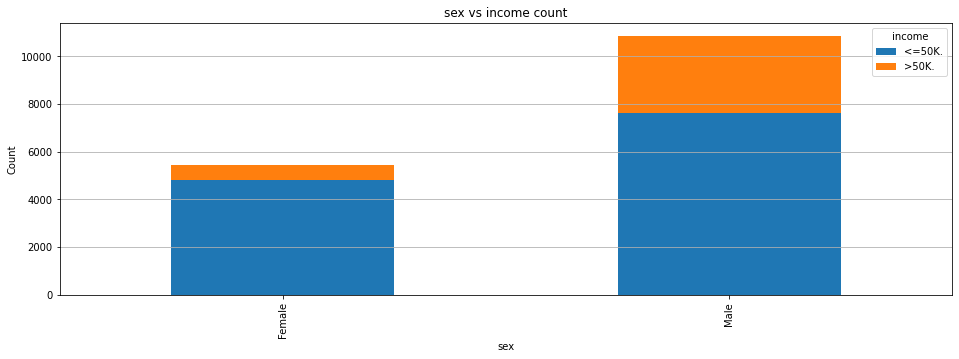

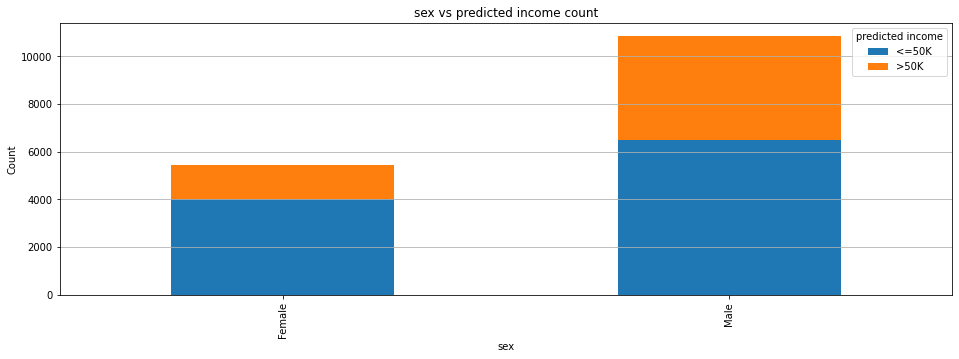

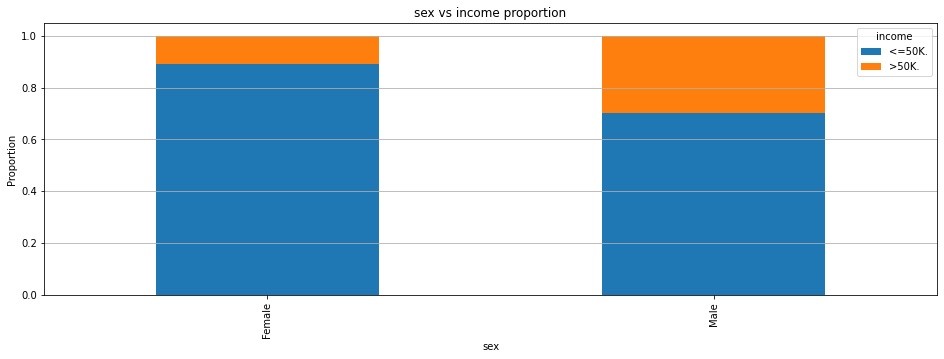

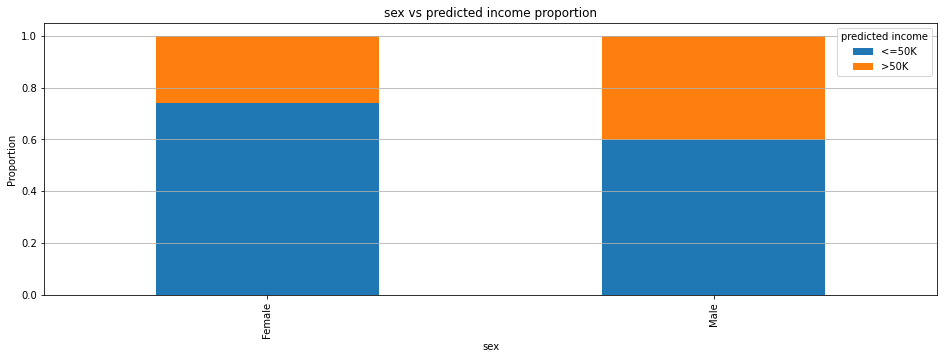

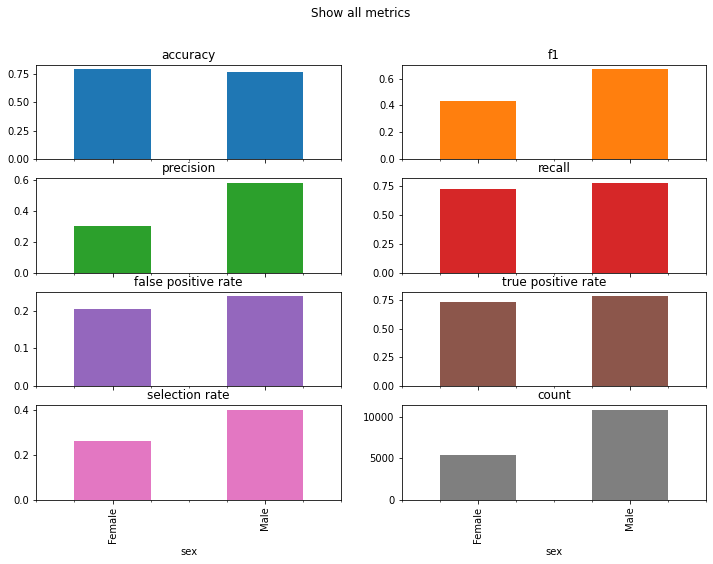

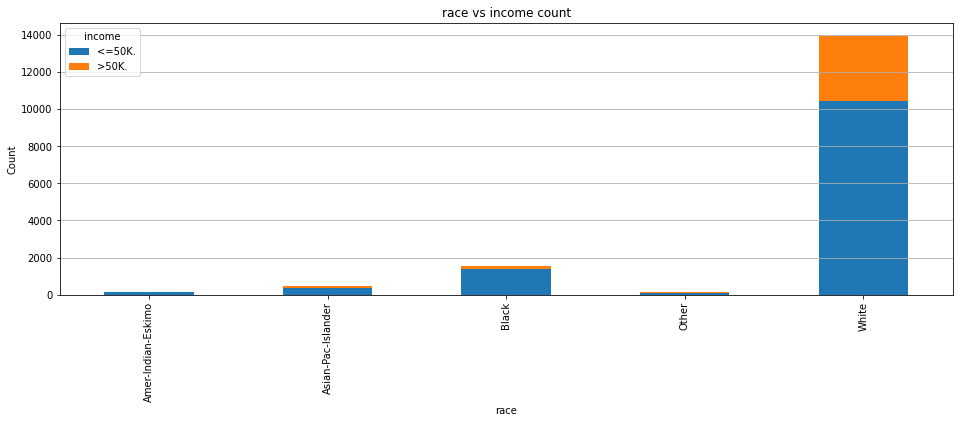

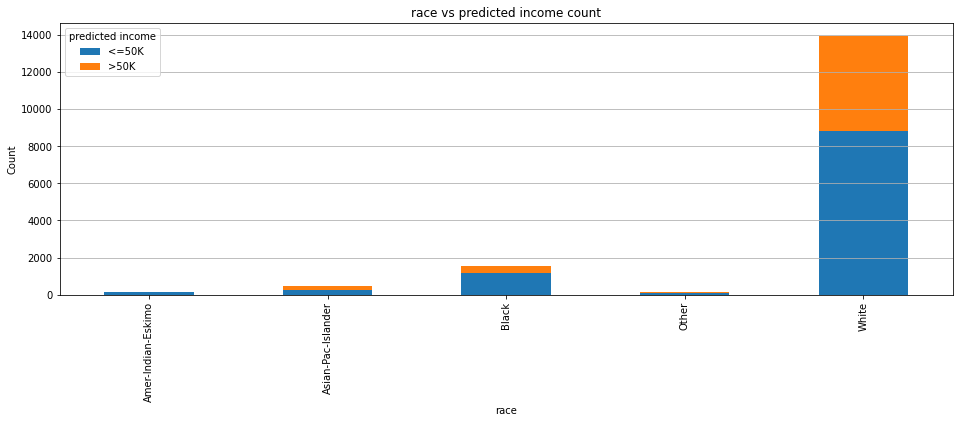

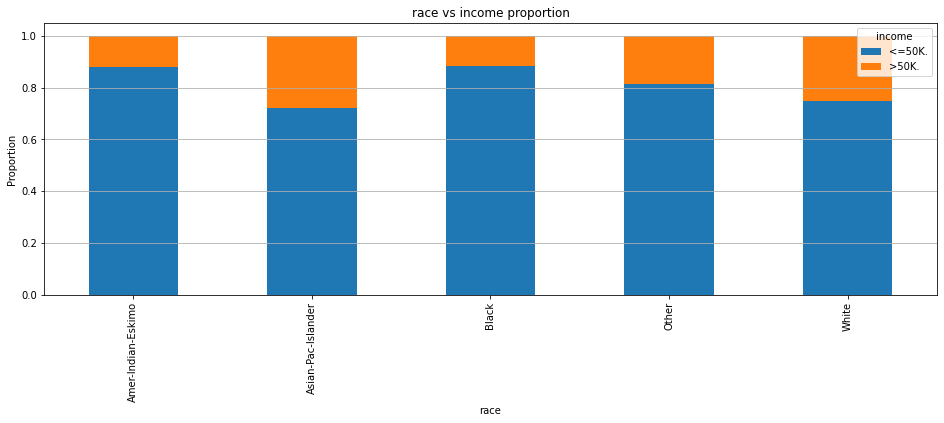

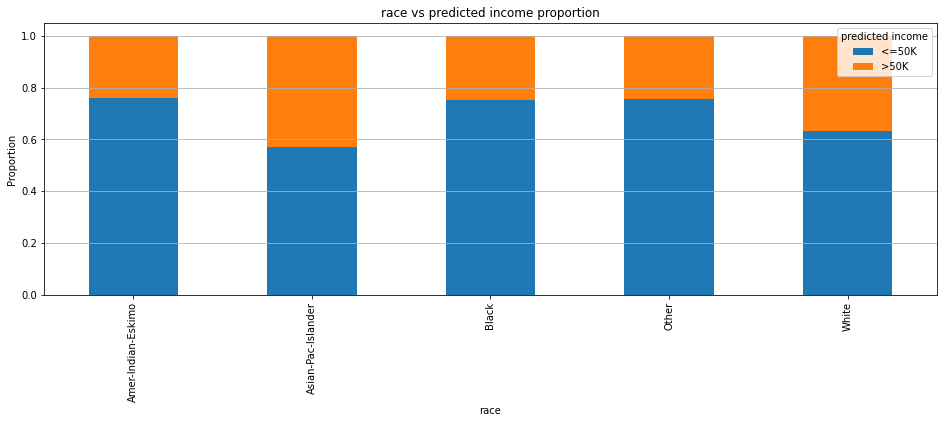

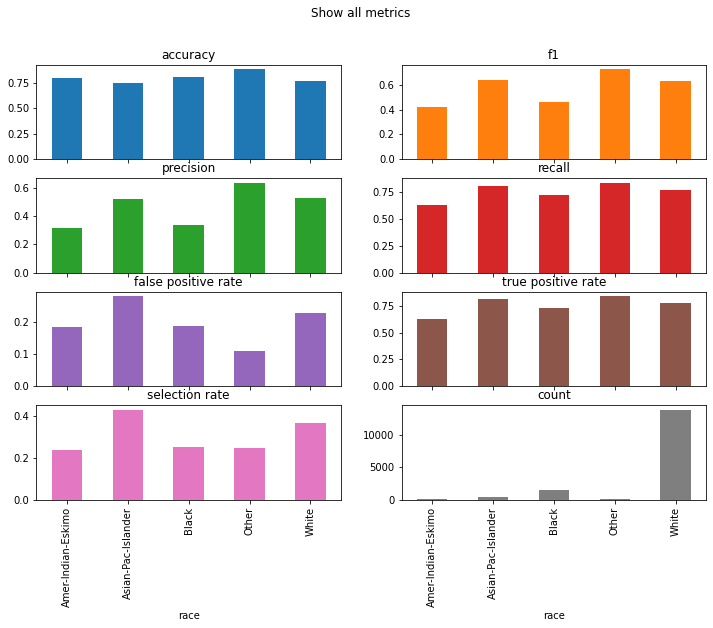

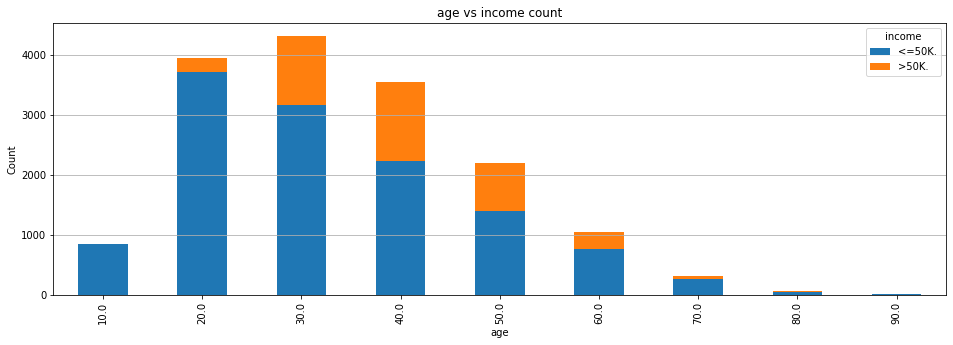

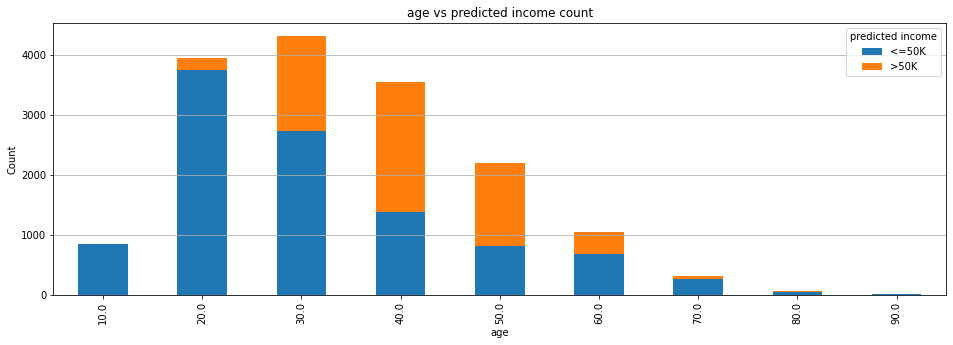

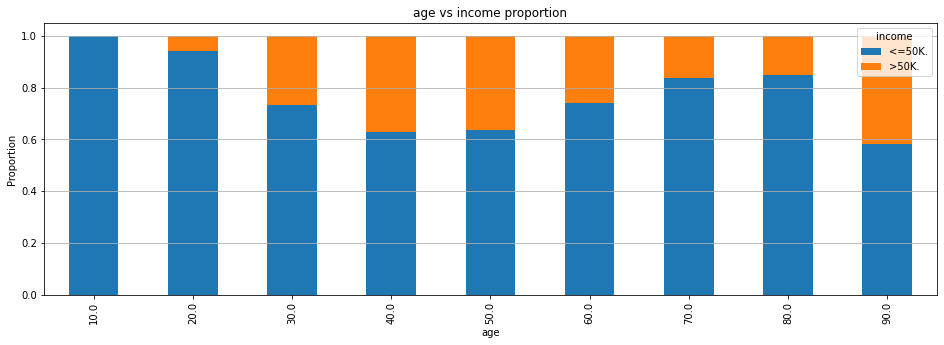

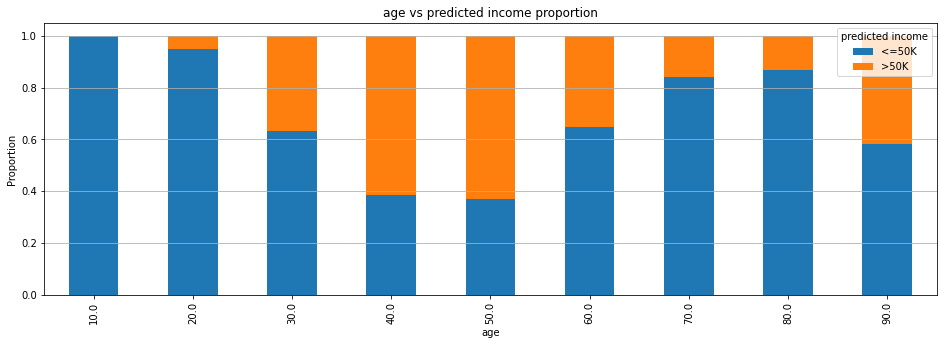

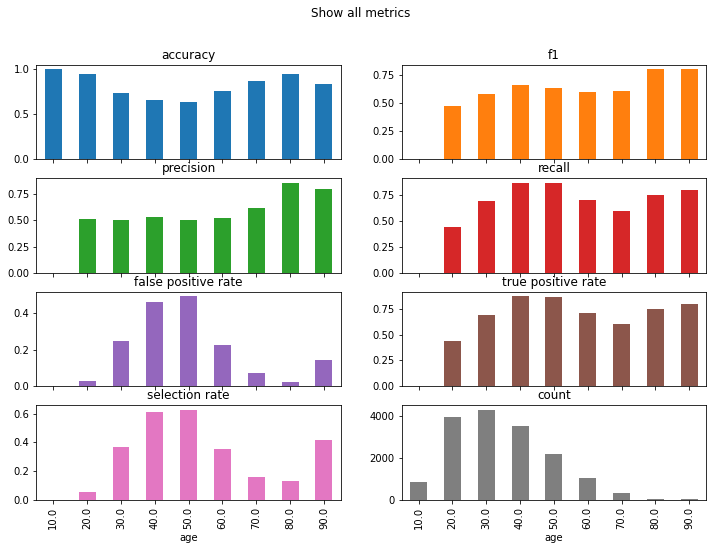

In [173]:
columns = ['sex', 'race', 'age']
for col in columns:
    plotOccurence(gold_data, col, LABEL_COLUMN)
    plotOccurence(pred_data, col, PRED_COLUMN)
    plotProportion(gold_data, col, LABEL_COLUMN)
    plotProportion(pred_data, col, PRED_COLUMN)
    draw_fairlearn_figure(Y_test, Y_pred, gold_data[col])